In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm

In [83]:
tickers = ['PEP', 'KO']
data = get_pricing(symbols(tickers), start_date='2006-01-01', end_date='2008-08-01',
                  fields='close_price', frequency='daily')
data.head()

,Equity(5885 [PEP]),Equity(4283 [KO])
2006-01-03 00:00:00+00:00,56.785,38.273
2006-01-04 00:00:00+00:00,56.747,38.208
2006-01-05 00:00:00+00:00,56.424,38.404
2006-01-06 00:00:00+00:00,56.633,38.732
2006-01-09 00:00:00+00:00,56.367,38.938


In [84]:
data.columns

Index([Equity(5885 [PEP]), Equity(4283 [KO])], dtype='object')

In [85]:
data.columns = [ticker.symbol for ticker in data.columns]
data.index.name = 'Date'
data.head()

,PEP,KO
Date,,
2006-01-03 00:00:00+00:00,56.785,38.273
2006-01-04 00:00:00+00:00,56.747,38.208
2006-01-05 00:00:00+00:00,56.424,38.404
2006-01-06 00:00:00+00:00,56.633,38.732
2006-01-09 00:00:00+00:00,56.367,38.938


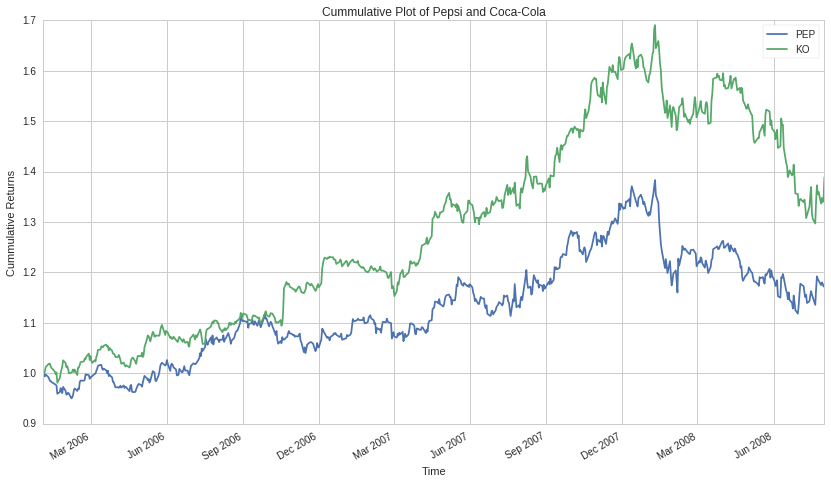

In [86]:
cumm_rtn = (1 + data.pct_change()).cumprod()
cumm_rtn.plot();
plt.ylabel('Cummulative Returns');
plt.xlabel('Time');
plt.title('Cummulative Plot of Pepsi and Coca-Cola');

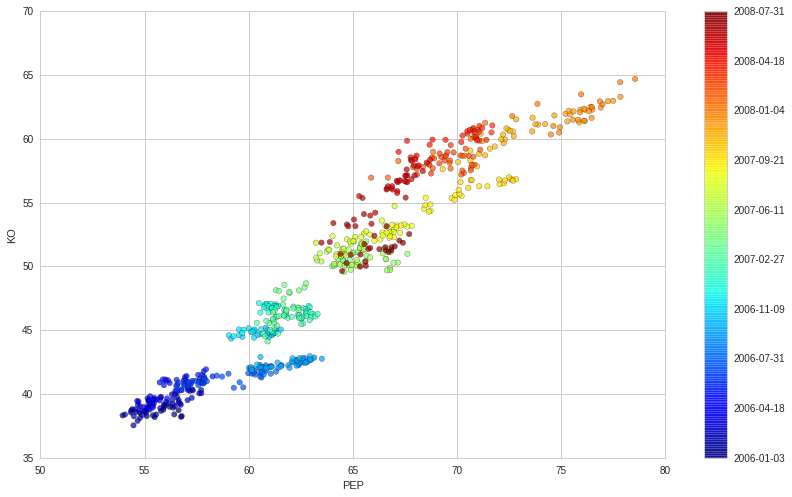

In [28]:
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30,
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

# Estimate with stats model

In [87]:
X = sm.add_constant(data[tickers[0]], prepend = False)
ols = sm.OLS(data[tickers[1]], X).fit()
beta = ols.params
y_fit = [X.min().dot(beta), X.max().dot(beta)]

In [88]:
print(ols.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.919    
Dependent Variable: KO               AIC:                2837.4049
Date:               2018-08-25 16:27 BIC:                2846.3588
No. Observations:   650              Log-Likelihood:     -1416.7  
Df Model:           1                F-statistic:        7355.    
Df Residuals:       648              Prob (F-statistic): 0.00     
R-squared:          0.919            Scale:              4.5919   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
PEP          1.2688    0.0148   85.7605  0.0000    1.2397    1.2978
const      -31.9220    0.9511  -33.5622  0.0000  -33.7896  -30.0543
------------------------------------------------------------------
Omnibus:              8.992         Durbin-Watson:           0.082
Prob(Om

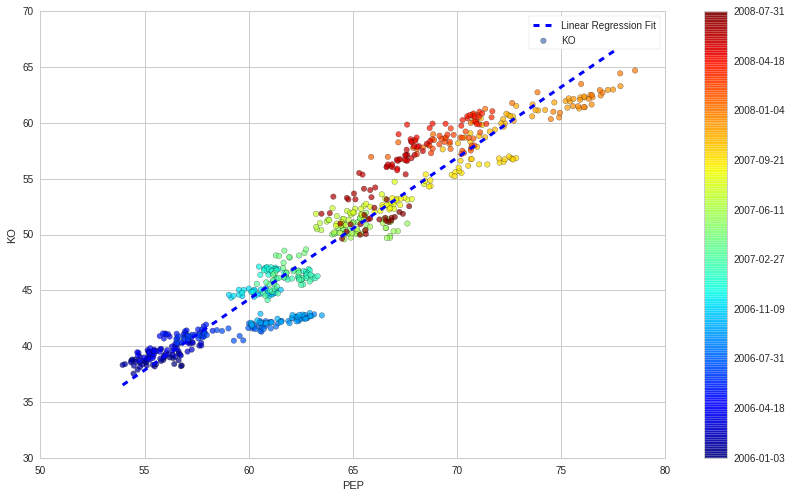

In [89]:
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30,
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([X.min()[0], X.max()[0]], y_fit, '--b', linewidth=3, label ='Linear Regression Fit')
plt.legend()

cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

# Linear Regression with scikit-learn

In [90]:
from sklearn.linear_model import LinearRegression

In [91]:
reg = LinearRegression(fit_intercept = True)
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
reg.fit(data[tickers[0]].reshape(-1,1), data[tickers[1]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
print(reg.coef_)

[ 1.26875149]


# Modeling the spread

$$\varepsilon = y - \beta_1 x - \beta_0$$

In [94]:
spread = pd.DataFrame(data[tickers[1]] - beta[0] * data[tickers[0]] - beta[1])

In [95]:
spread.columns = ['in-sample']
spread.head()

,in-sample
Date,
2006-01-03 00:00:00+00:00,-1.851078
2006-01-04 00:00:00+00:00,-1.867866
2006-01-05 00:00:00+00:00,-1.262059
2006-01-06 00:00:00+00:00,-1.199228
2006-01-09 00:00:00+00:00,-0.655740


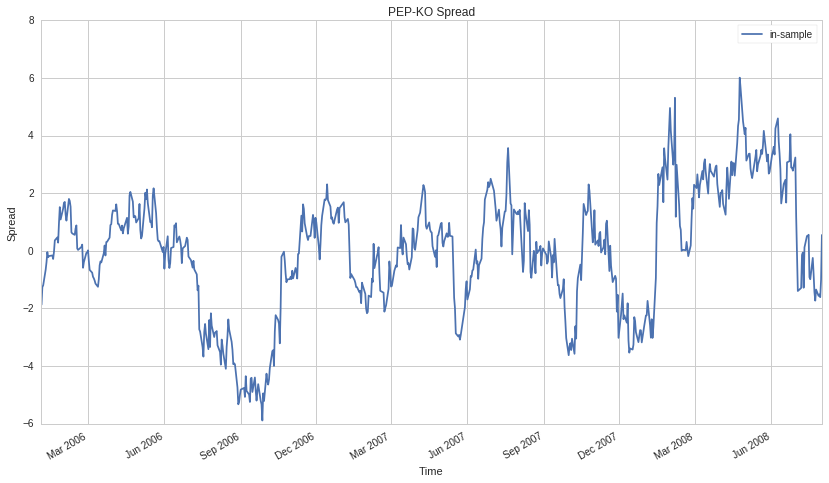

In [96]:
spread.plot()
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('PEP-KO Spread')

# Testing for Cointegration

In [97]:
adf = statsmodels.tsa.stattools.adfuller(spread['in-sample'], maxlag = 1)
print('ADF test statistics: {:.03f}').format(adf[0])
print('p-value: {:.03f}').format(adf[1])

ADF test statistics: -3.411
p-value: 0.011


# Trading Logic

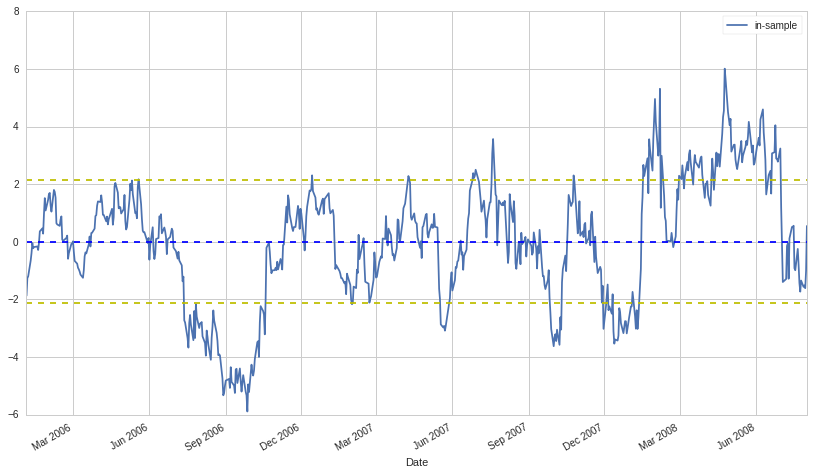

In [98]:
spread.plot()
plt.axhline(spread['in-sample'].mean(), ls='--', color='b')
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls='--', color='y')
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls='--', color='y')

# Out of Sample / Test

In [99]:

data_oos = get_pricing(symbols(tickers), start_date='2008-08-01', end_date='2010-01-01',
                  fields='close_price', frequency='daily')
data_oos.columns = [ticker.symbol for ticker in data_oos.columns]
data_oos.index.name = 'Date'
data_oos.head()

,PEP,KO
Date,,
2008-08-01 00:00:00+00:00,63.622,50.566
2008-08-04 00:00:00+00:00,64.605,51.261
2008-08-05 00:00:00+00:00,65.455,52.193
2008-08-06 00:00:00+00:00,65.427,52.678
2008-08-07 00:00:00+00:00,64.911,51.394


In [100]:
spread_oos = spread.reindex((spread.index).union(data_oos.index))

In [101]:
spread_oos['out-of-sample'] = data_oos[tickers[1]] - beta[0] * data_oos[tickers[0]] - beta[1]
spread_oos.tail()

,in-sample,out-of-sample
Date,,
2009-12-24 00:00:00+00:00,NaN,12.105009
2009-12-28 00:00:00+00:00,NaN,11.762446
2009-12-29 00:00:00+00:00,NaN,12.151259
2009-12-30 00:00:00+00:00,NaN,11.838259
2009-12-31 00:00:00+00:00,NaN,11.789947


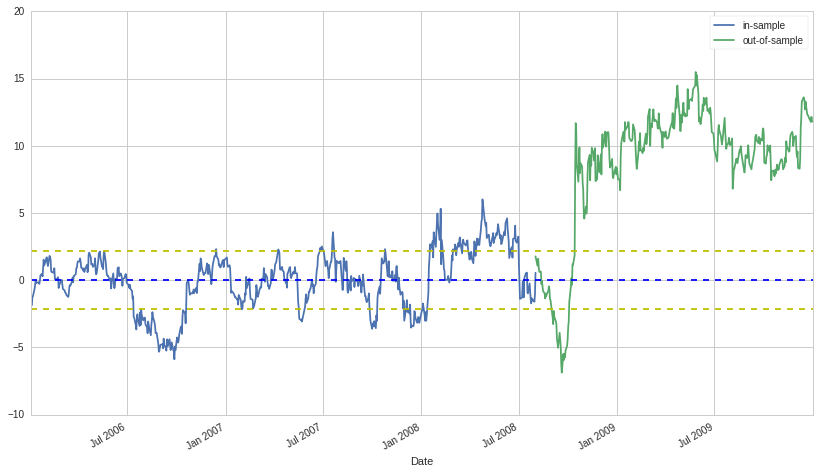

In [81]:
spread_oos.plot()
plt.axhline(spread['in-sample'].mean(), ls='--', color='b')
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls='--', color='y')
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls='--', color='y')

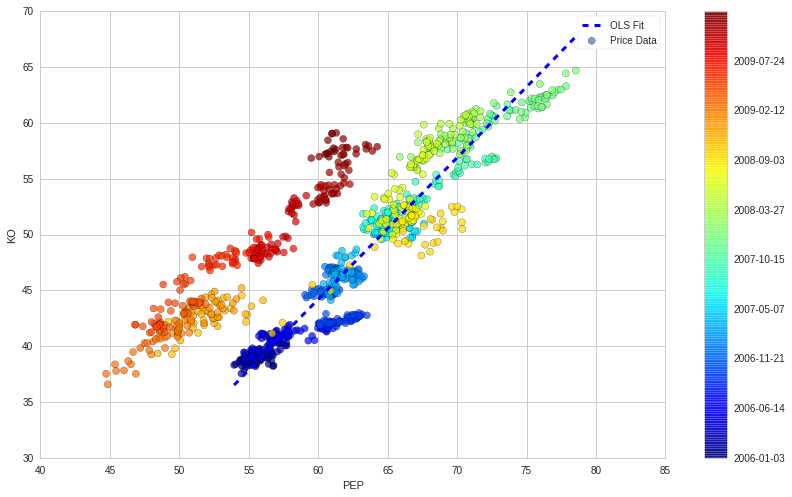

In [105]:
data_all = data.append(data_oos)
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], s=50, c=colors,
                cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([X.min()[0], X.max()[0]], y_fit, '--b', linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])